In [1]:
import pandas as pd
data_raw = pd.read_csv(
    filepath_or_buffer='data/total_delays_state.csv',
    index_col=0
)

data_raw.columns = pd.to_datetime(data_raw.columns)

In [2]:
data_raw

2016-01-01  2016-01-02  2016-01-03  2016-01-04  2016-01-05  \
DestState                                                               
AZ              742.0      2262.0      1095.0      1247.0      1197.0   
CA             2552.0      2849.0      5492.0      8256.0      6821.0   
CO              711.0      1361.0      1172.0      1206.0       670.0   
GA              378.0       393.0       908.0       902.0       805.0   
IL              331.0       517.0      1831.0      1691.0      1102.0   
NC              171.0       448.0       651.0       640.0       846.0   
TX             2747.0      1089.0      2517.0      1114.0      1972.0   

           2016-01-06  2016-01-07  2016-01-08  2016-01-09  2016-01-10  ...  \
DestState                                                              ...   
AZ             1481.0      1400.0      1263.0       859.0       596.0  ...   
CA            12656.0      4238.0      3912.0      1132.0      2024.0  ...   
CO              946.0       969.0      1303.0       627.0      1332.0  ...   
GA             1011.0       810.0       769.0       713.0      1203.0  ...   
IL              720.0       813.0      1114.0      1116.0       519.0  ...   
NC              460.0       381.0       521.0       415.0      1136.0  ...   
TX             1584.0      1776.0      2975.0      1315.0      2160.0  ...   

           2018-12-22  2018-12-23  2018-12-24  2018-12-25  2018-12-26  \
DestState                                                               
AZ              970.0      1048.0       477.0       305.0      1456.0   
CA             2834.0      2386.0      3587.0       434.0      5847.0   
CO             1076.0      1660.0       188.0       264.0      1727.0   
GA              706.0       275.0       382.0       102.0      2254.0   
IL             1228.0       583.0       571.0       297.0      1522.0   
NC              430.0       302.0        50.0        73.0       447.0   
TX              962.0      1251.0       942.0      1889.0      9277.0   

           2018-12-27  2018-12-28  2018-12-29  2018-12-30  2018-12-31  
DestState                                                              
AZ             1975.0      1479.0      1212.0      1097.0      1590.0  
CA             5494.0      4323.0      1667.0      3193.0      2744.0  
CO             2905.0      2111.0      1420.0      1474.0      1481.0  
GA             2365.0      2006.0       992.0       444.0      1186.0  
IL             2962.0      2759.0      1843.0       762.0      1090.0  
NC             1742.0      1589.0       893.0       701.0       572.0  
TX             9665.0      3520.0      1889.0      1832.0      2414.0  

[7 rows x 1095 columns]

In [3]:
import matplotlib.pyplot as plt

def plot_time_series(df, destinations, title_prefix=''):
    dates = pd.to_datetime(df.columns)
    num_states = len(destinations)

    df_plot = df.loc[destinations].T
    
    plt.figure(figsize=(12, 10))
    for i, state in enumerate(destinations, start=1):
        plt.subplot(num_states, 1, i)
        plt.plot(dates, df_plot[state])
        plt.title(f"{title_prefix}{state}")
        plt.ylabel("Total Delays")
        plt.xticks(rotation=45)
        plt.grid(alpha=0.3)
    
    plt.xlabel("Date")
    plt.show()

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_arr = scaler.fit_transform(data_raw)
df_scaled = pd.DataFrame(
    scaled_arr,
    index=data_raw.index,     
    columns=data_raw.columns   
)

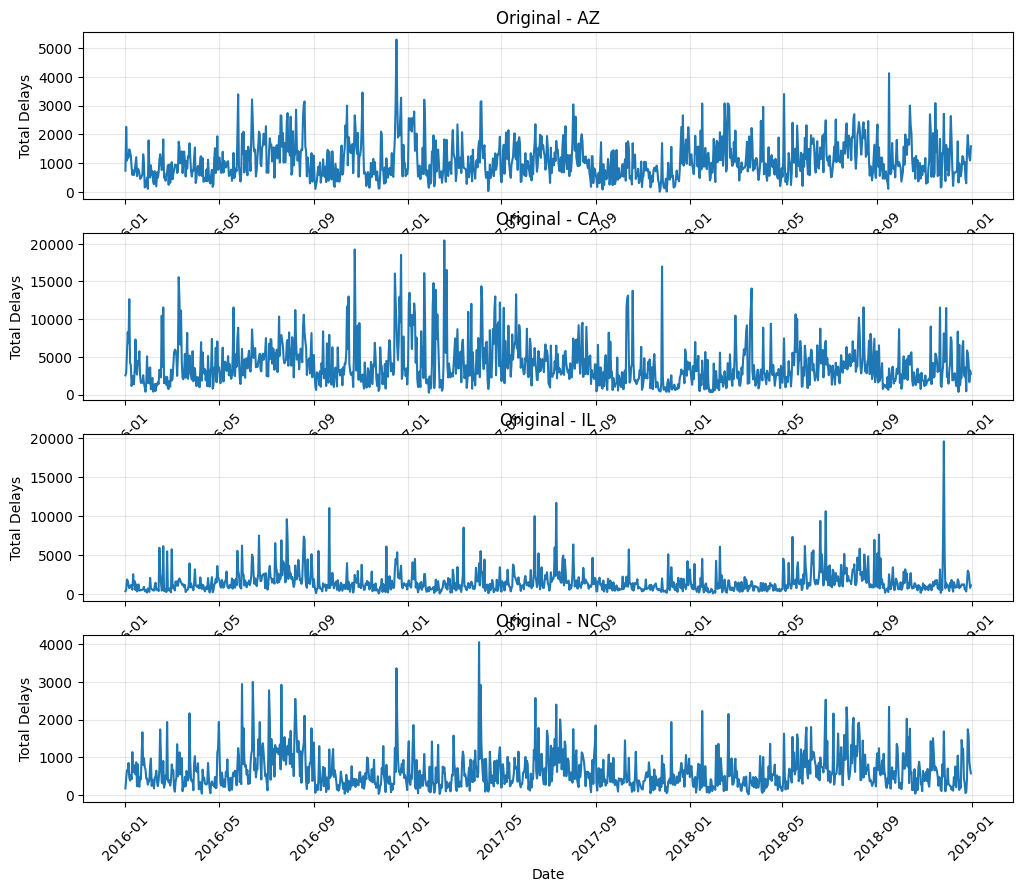

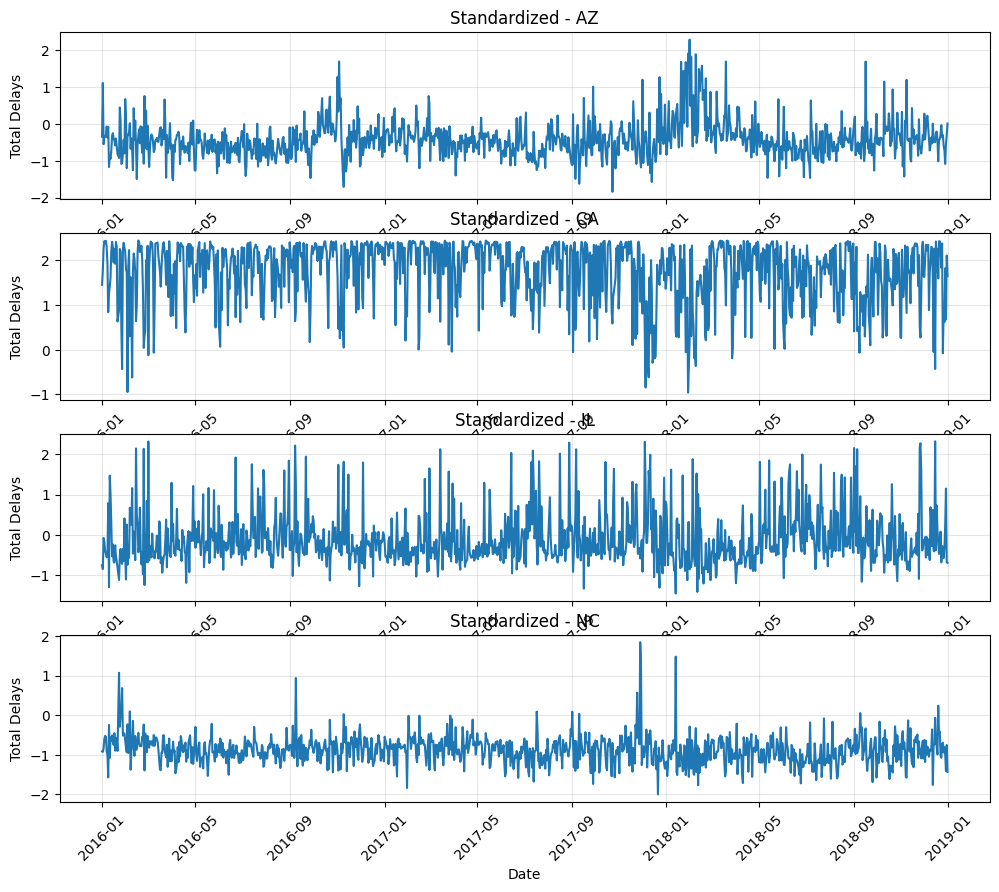

In [5]:
states = ['AZ', 'CA', 'IL', 'NC']

plot_time_series(data_raw, states, title_prefix="Original - ")
plot_time_series(df_scaled, states, title_prefix="Standardized - ")

Spikes indicate higher delays relative to other states while lows mean less delays relative to other states. A positive number indicates the delay experienced is above average for that particular day while a negative is the opposite.

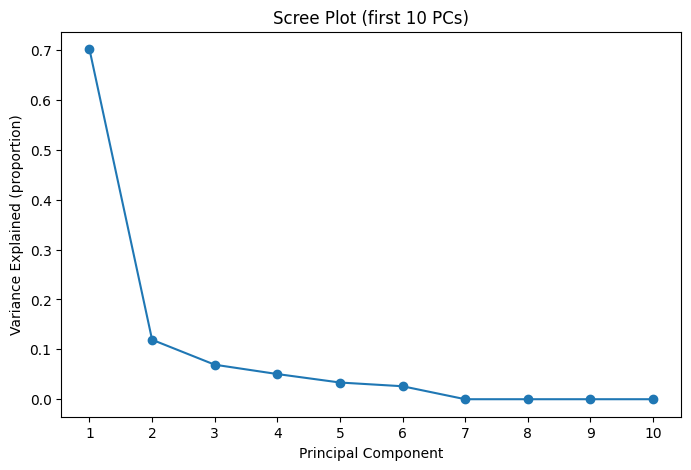

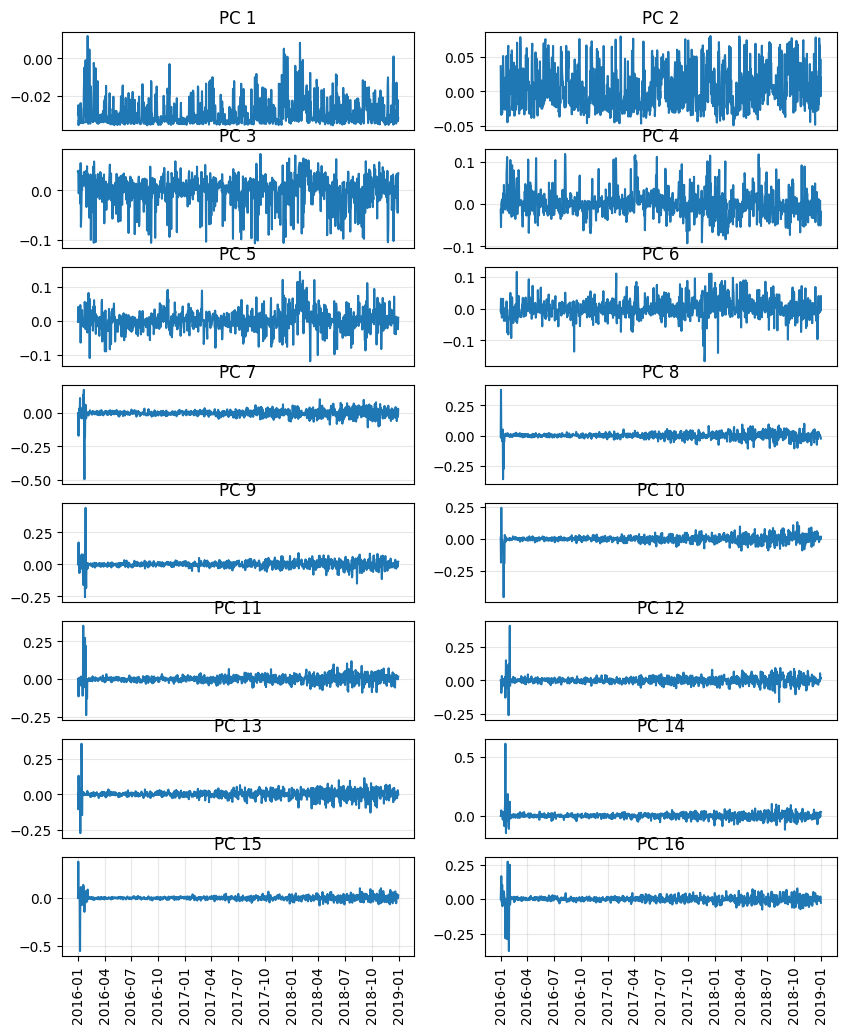

In [6]:
import numpy as np
import matplotlib.dates as mdates

df_cov = df_scaled.cov()

def get_sorted_eigen(df_cov):
    cov_matrix = df_cov.values
    
    eigvals, eigvecs = np.linalg.eigh(cov_matrix)
    
    idx = np.argsort(eigvals)[::-1]
    sorted_eigvals = eigvals[idx]
    sorted_eigvecs = eigvecs[:, idx]
    
    return sorted_eigvals, sorted_eigvecs

def scree_plot(eigvals, k=10):
    total_variance = eigvals.sum()
    variance_exp = eigvals/total_variance
    pcs = np.arange(1, k+1)

    plt.figure(figsize=(8,5))
    plt.plot(pcs, variance_exp[:k], marker='o')
    plt.xticks(pcs)
    plt.xlabel("Principal Component")
    plt.ylabel("Variance Explained (proportion)")
    plt.title(f"Scree Plot (first {k} PCs)")
    plt.show()
    
def num_pcs_for_variances(eigvals, threshold=0.9):
    tot_variance = eigvals.sum()
    variance_ratio = eigvals/tot_variance
    cuma_variance = np.cumsum(variance_ratio)
    k = np.searchsorted(cuma_variance, threshold)+1
    return k, cuma_variance
    
def plot_first_16(eigvecs, date_index):
    num_pcs = 16
    
    plt.figure(figsize=(10,12))
    for i in range(num_pcs):
        plt.subplot(8, 2, i+1)  
        plt.plot(date_index, eigvecs[:, i])
        plt.title(f"PC {i+1}")
        plt.grid(alpha=0.3)
        ax = plt.gca()
        
        if i >= 14:  
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
            plt.xticks(rotation=90)
        else:
            plt.xticks([]) 
            ax.xaxis.set_ticklabels([])  
    plt.show()

eigvals, eigvecs = get_sorted_eigen(df_cov)
scree_plot(eigvals)
num_pcs_for_variances(eigvals, threshold=0.9)
date_index = pd.to_datetime(data_raw.columns)
plot_first_16(eigvecs, date_index)

We need 4 principal components to cover atleast 90% of the variance.

The first few PCs capture clear, strong patterns over time, with noticeable trends and larger movements. The later PCs look much noisier and flatter, with no real structure. They mostly represent small, random fluctuations rather than meaningful variation.

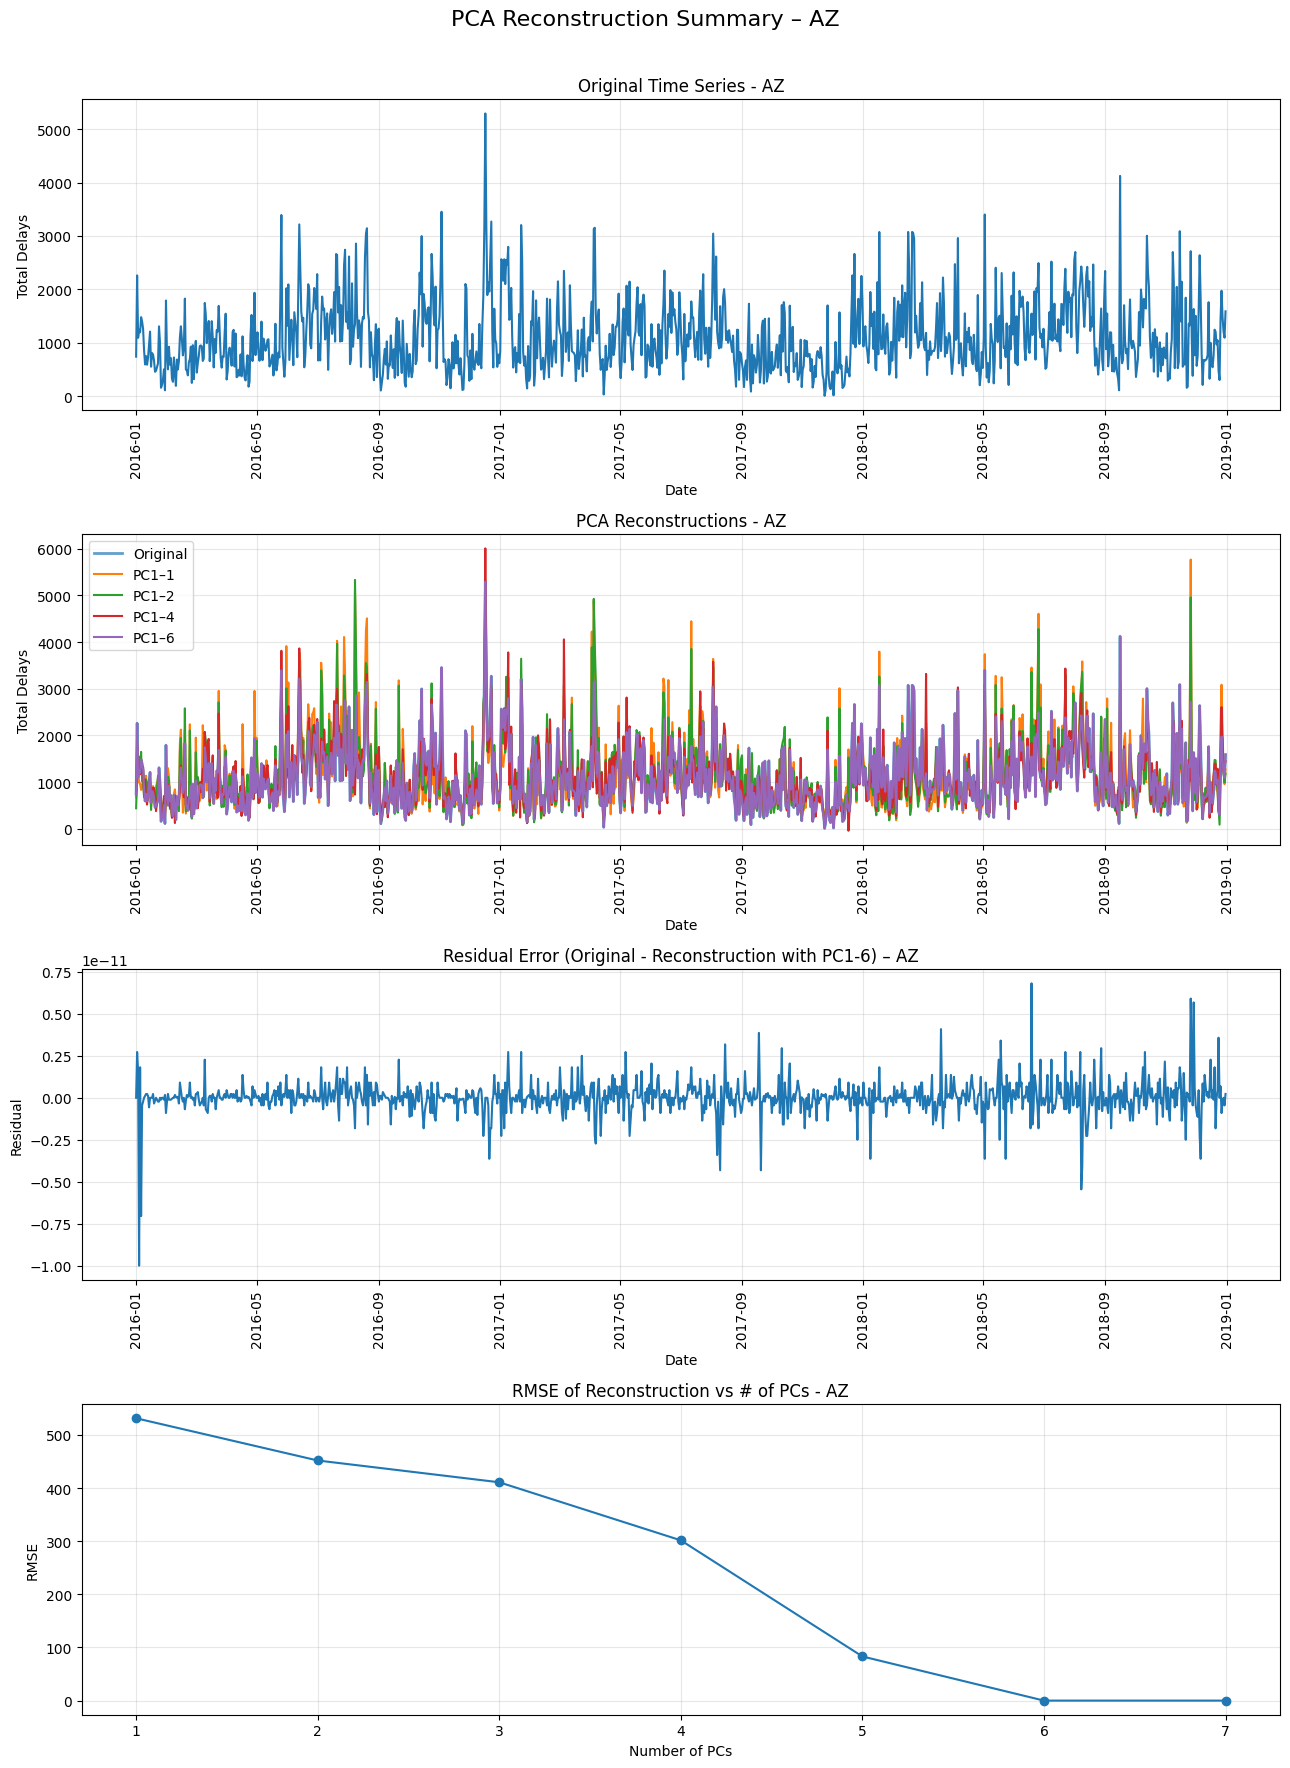

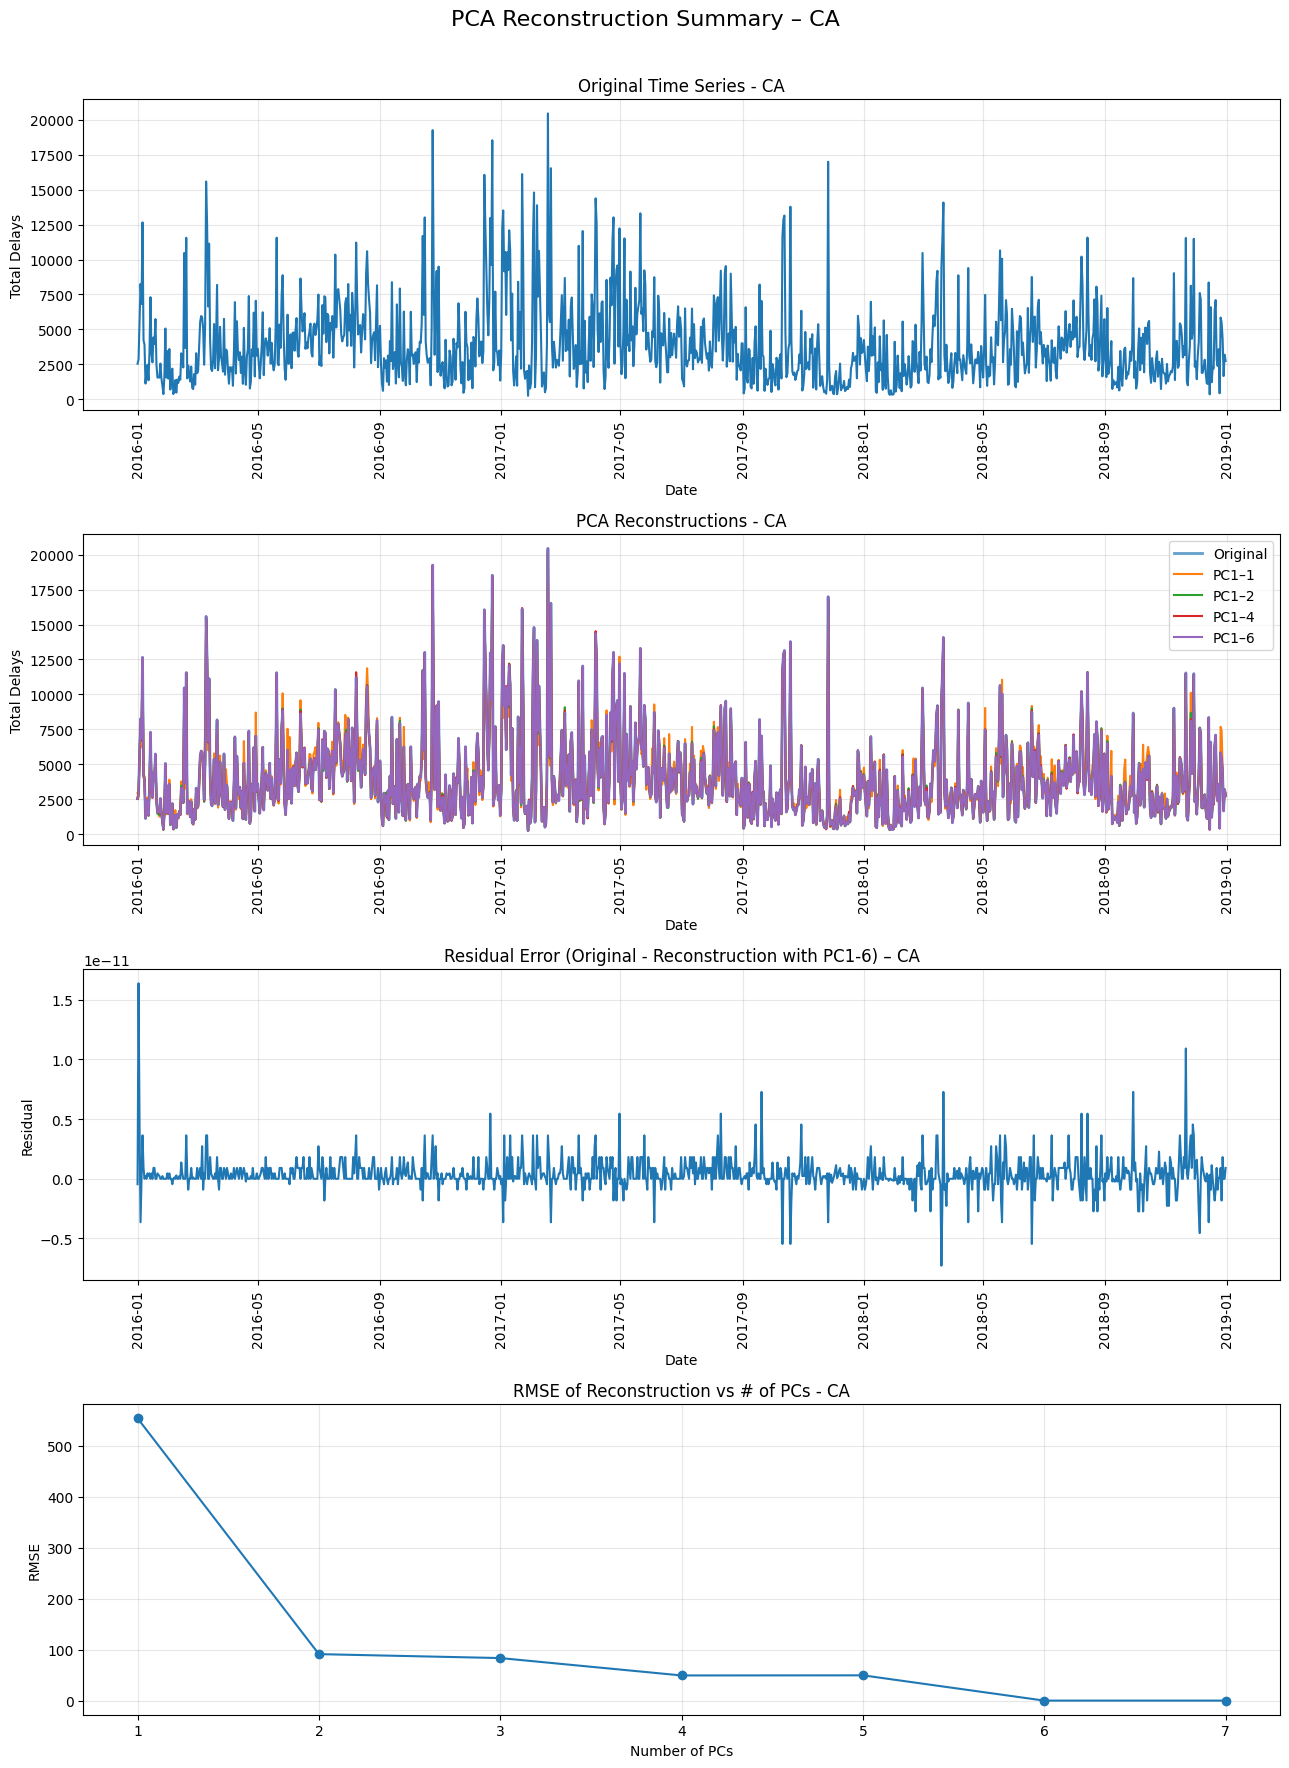

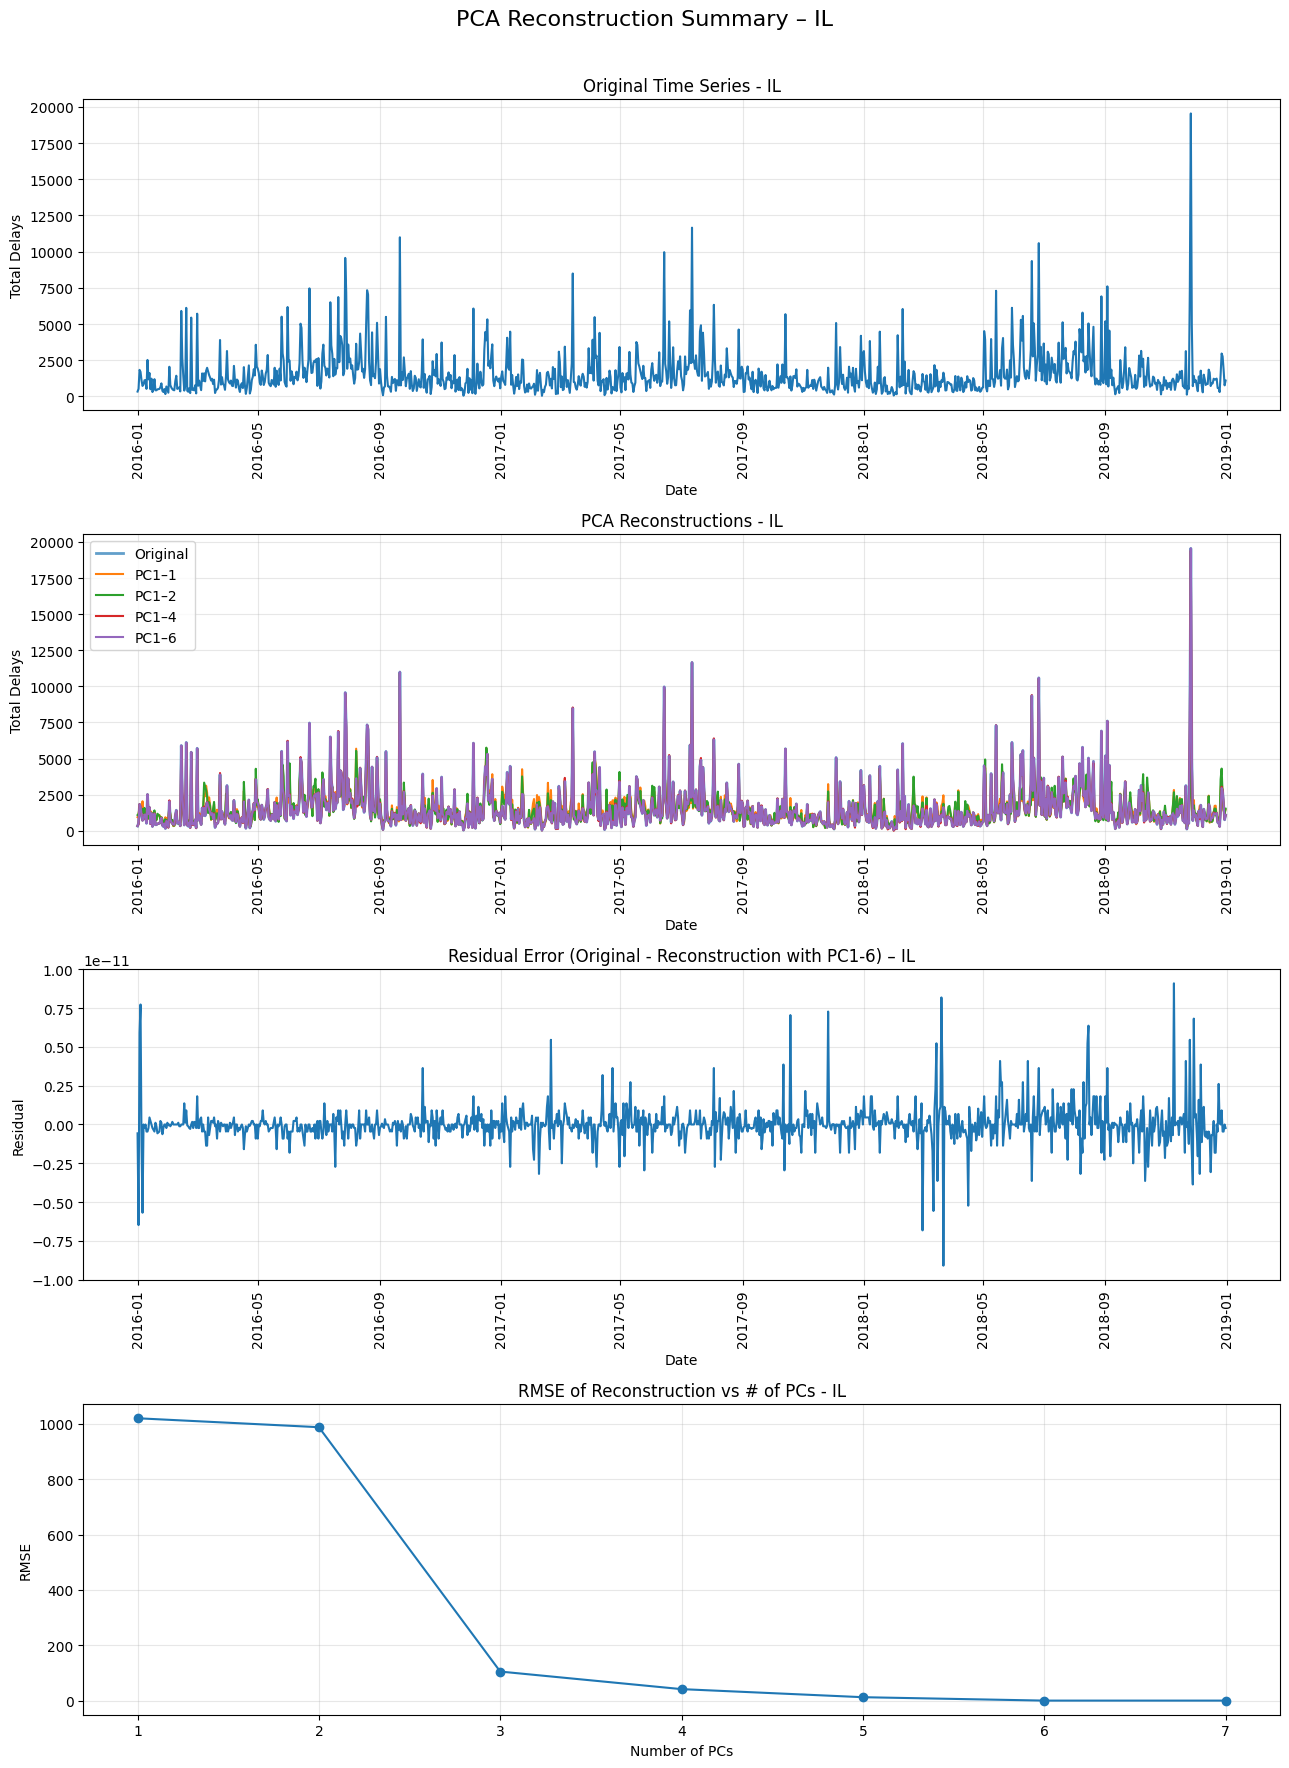

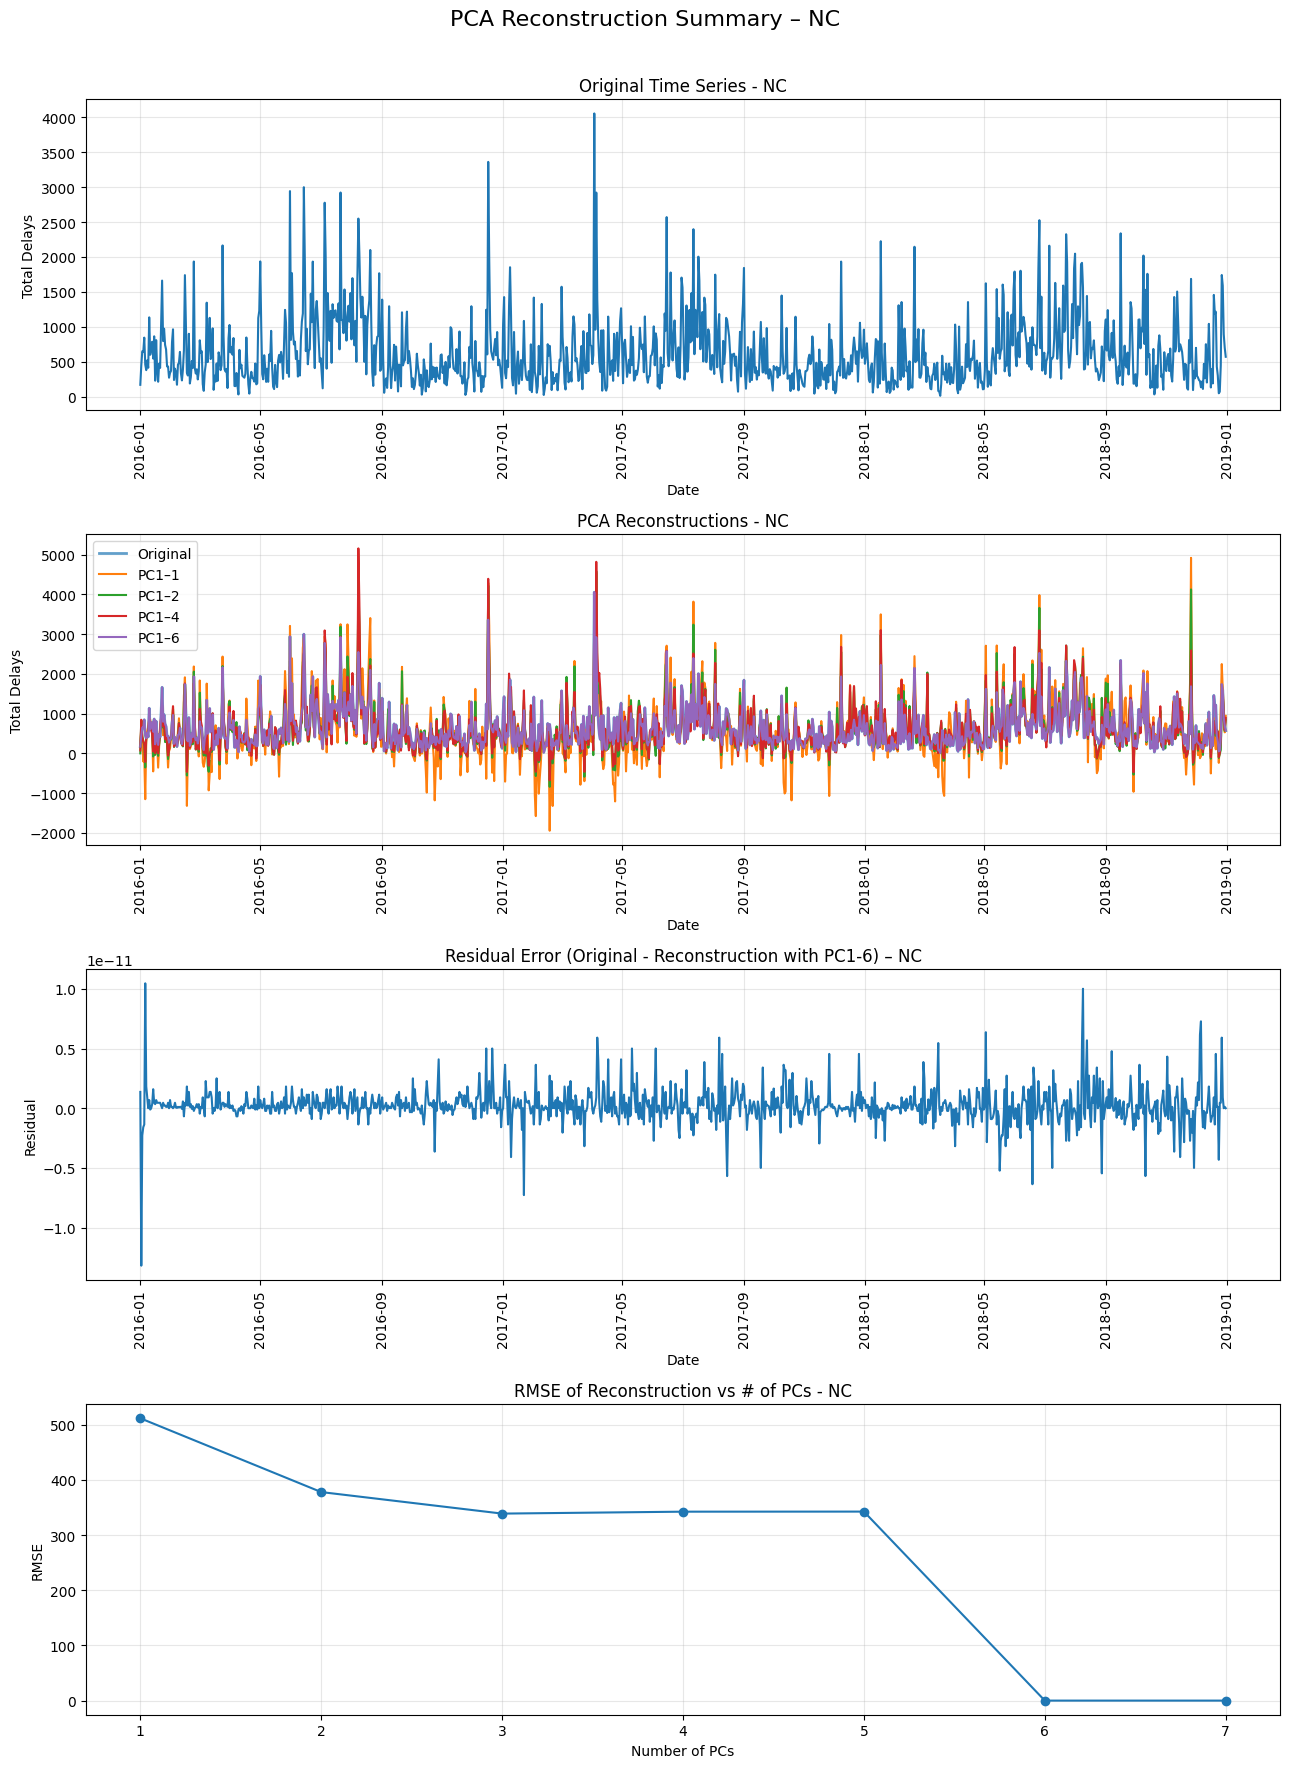

In [7]:
def pca_reconstruction_plotting(df, destination):
    dates = df.columns
    X_og = df.loc[destination].values
    
    scaler = StandardScaler()
    X_std = scaler.fit_transform(df.values)
    df_std = pd.DataFrame(X_std, index=df.index, columns=df.columns)
    df_cov = df_std.cov()
    eigvals, eigvecs = get_sorted_eigen(df_cov)
    x_std = df_std.loc[destination].values.reshape(1, -1)
    
    def reconstruct_with_k(k):
        V_k = eigvecs[:, :k]                
        scores = x_std @ V_k                
        x_hat_std = scores @ V_k.T      
        x_hat_orig = scaler.inverse_transform(x_hat_std)[0]  
        return x_hat_orig

    fig, axs = plt.subplots(4, 1, figsize=(13, 18))
    fig.suptitle(f"PCA Reconstruction Summary – {destination}", fontsize=16)

    # Original time series
    axs[0].plot(dates, X_og)
    axs[0].set_title(f"Original Time Series - {destination}")
    axs[0].set_xlabel("Date")
    axs[0].set_ylabel("Total Delays")
    axs[0].tick_params(axis='x', rotation=90)
    axs[0].grid(alpha=0.3)

    # Incremental reconstructions
    ks = [1, 2, 4, 6]
    reconstructions = {}

    axs[1].plot(dates, X_og, label="Original", linewidth=2, alpha=0.7)

    for k in ks:
        x_hat = reconstruct_with_k(k)
        reconstructions[k] = x_hat
        axs[1].plot(dates, x_hat, label=f"PC1–{k}")

    axs[1].set_title(f"PCA Reconstructions - {destination}")
    axs[1].set_xlabel("Date")
    axs[1].set_ylabel("Total Delays")
    axs[1].tick_params(axis='x', rotation=90)
    axs[1].legend()
    axs[1].grid(alpha=0.3)

    # Residual error for best reconstruction
    best_k = 6
    x_best = reconstructions[best_k]
    residual = X_og - x_best

    axs[2].plot(dates, residual)
    axs[2].set_title(f"Residual Error (Original - Reconstruction with PC1-{best_k}) – {destination}")
    axs[2].set_xlabel("Date")
    axs[2].set_ylabel("Residual")
    axs[2].tick_params(axis='x', rotation=90)
    axs[2].grid(alpha=0.3)

    # RMSE vs number of components
    max_k = 7
    rmses = []

    for k in range(1, max_k + 1):
        x_hat_k = reconstruct_with_k(k)
        rmse_k = np.sqrt(np.mean((X_og - x_hat_k) ** 2))
        rmses.append(rmse_k)

    axs[3].plot(range(1, max_k + 1), rmses, marker='o')
    axs[3].set_title(f"RMSE of Reconstruction vs # of PCs - {destination}")
    axs[3].set_xlabel("Number of PCs")
    axs[3].set_ylabel("RMSE")
    axs[3].set_xticks(range(1, max_k + 1))
    axs[3].grid(alpha=0.3)

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

destinations = ["AZ", "CA", "IL", "NC"]
for dest in destinations:
    pca_reconstruction_plotting(data_raw, dest)

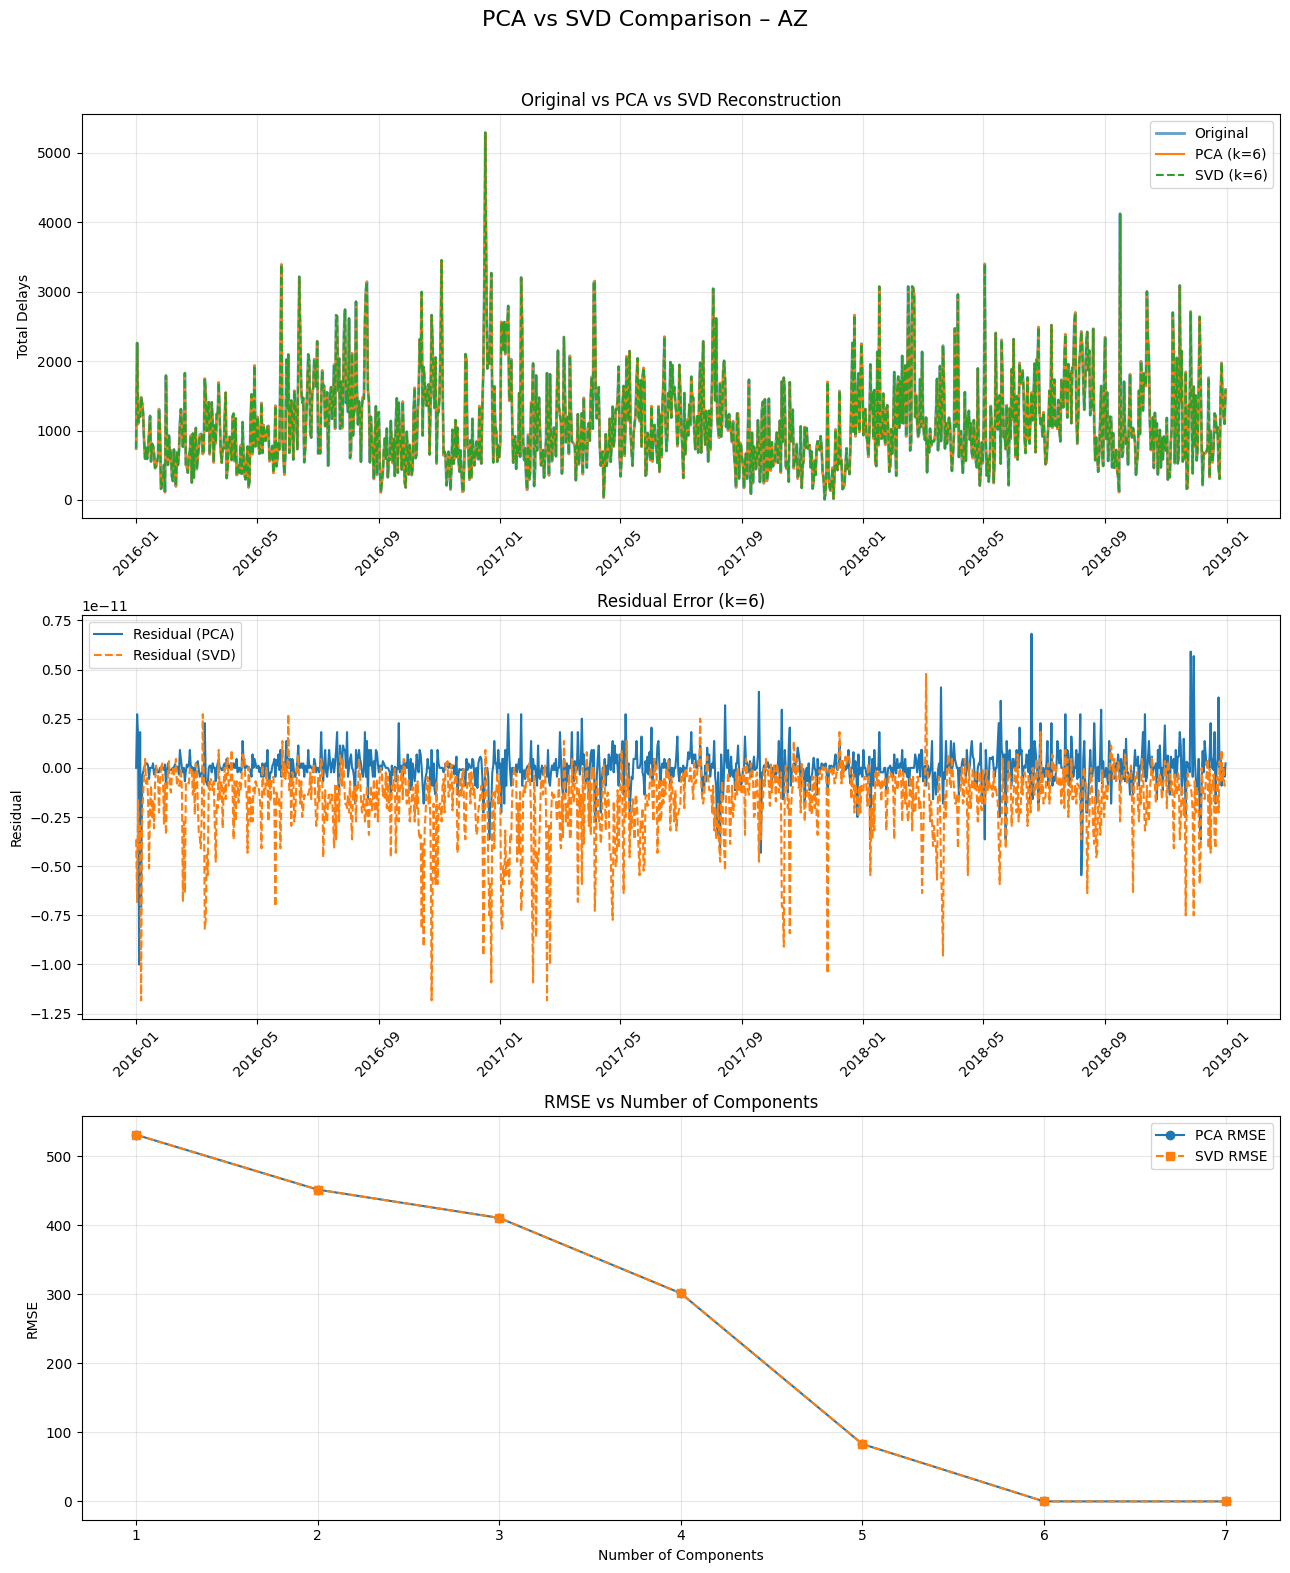

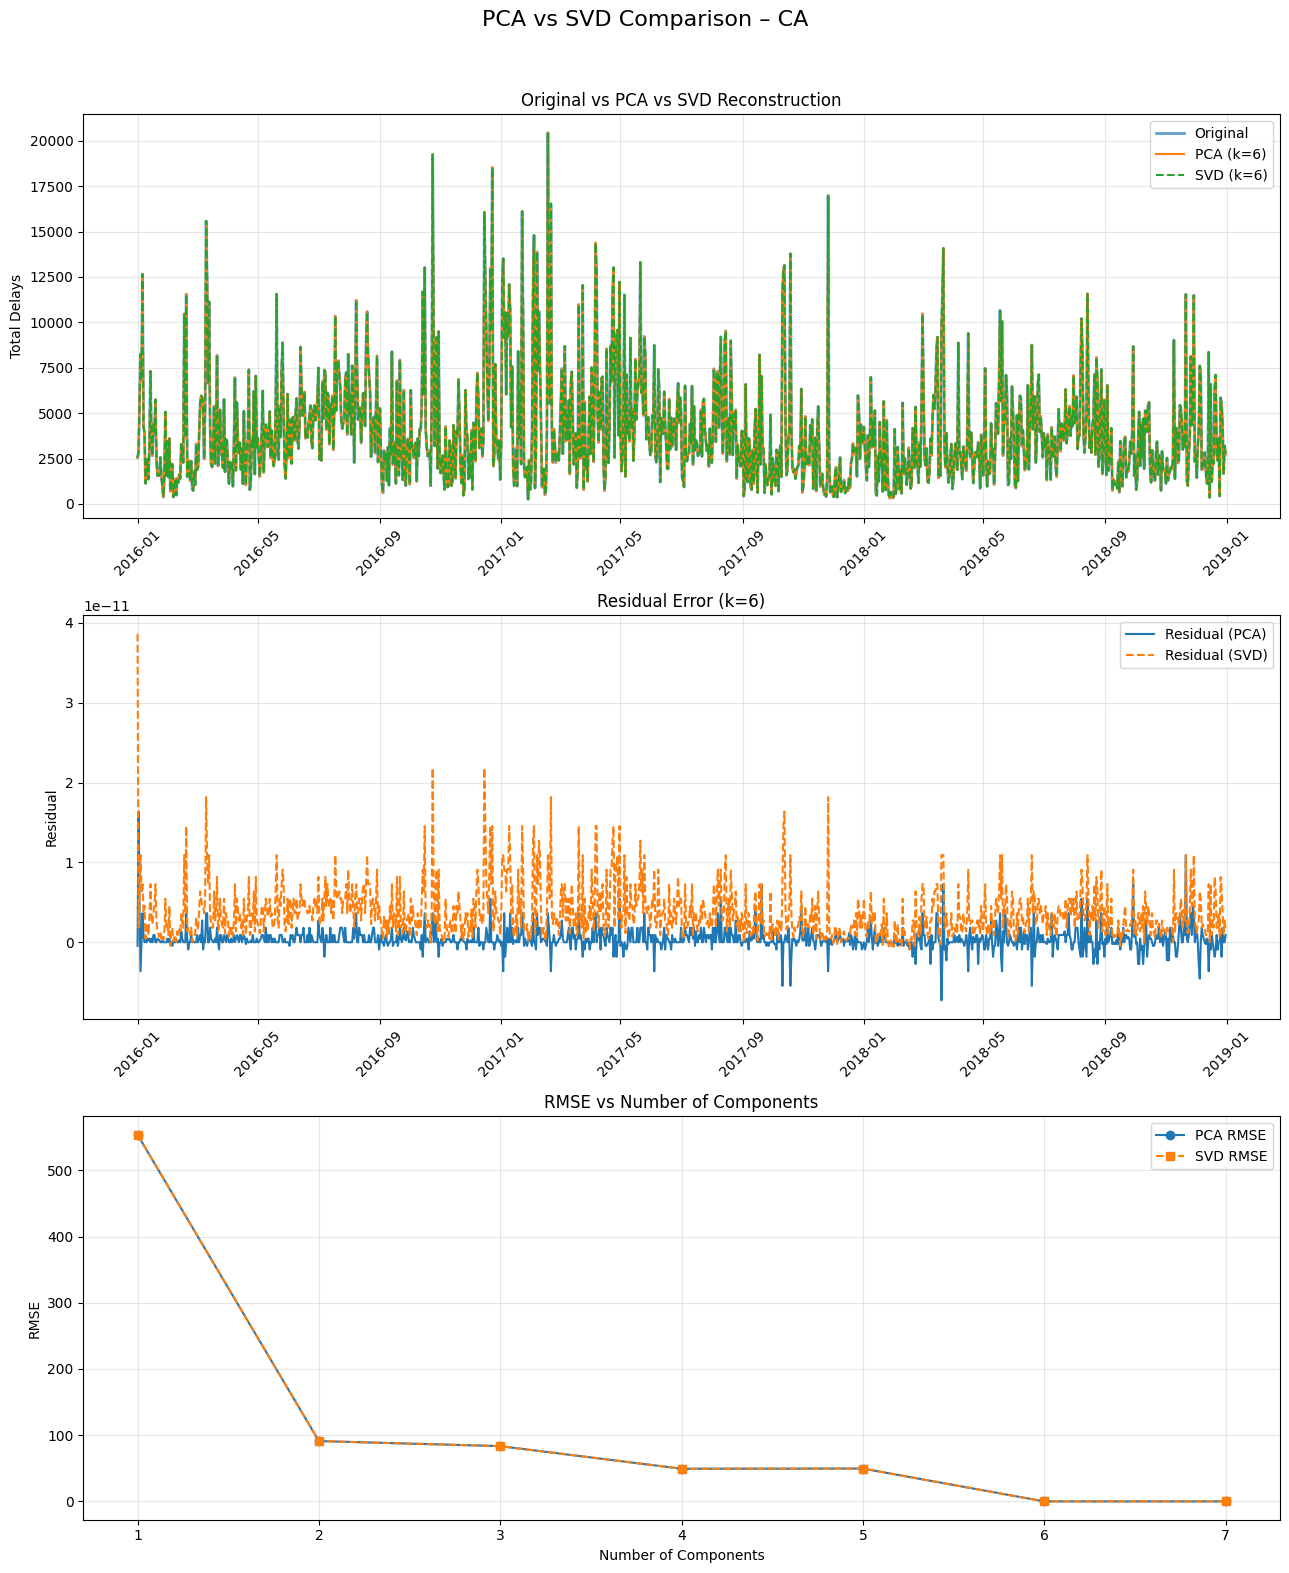

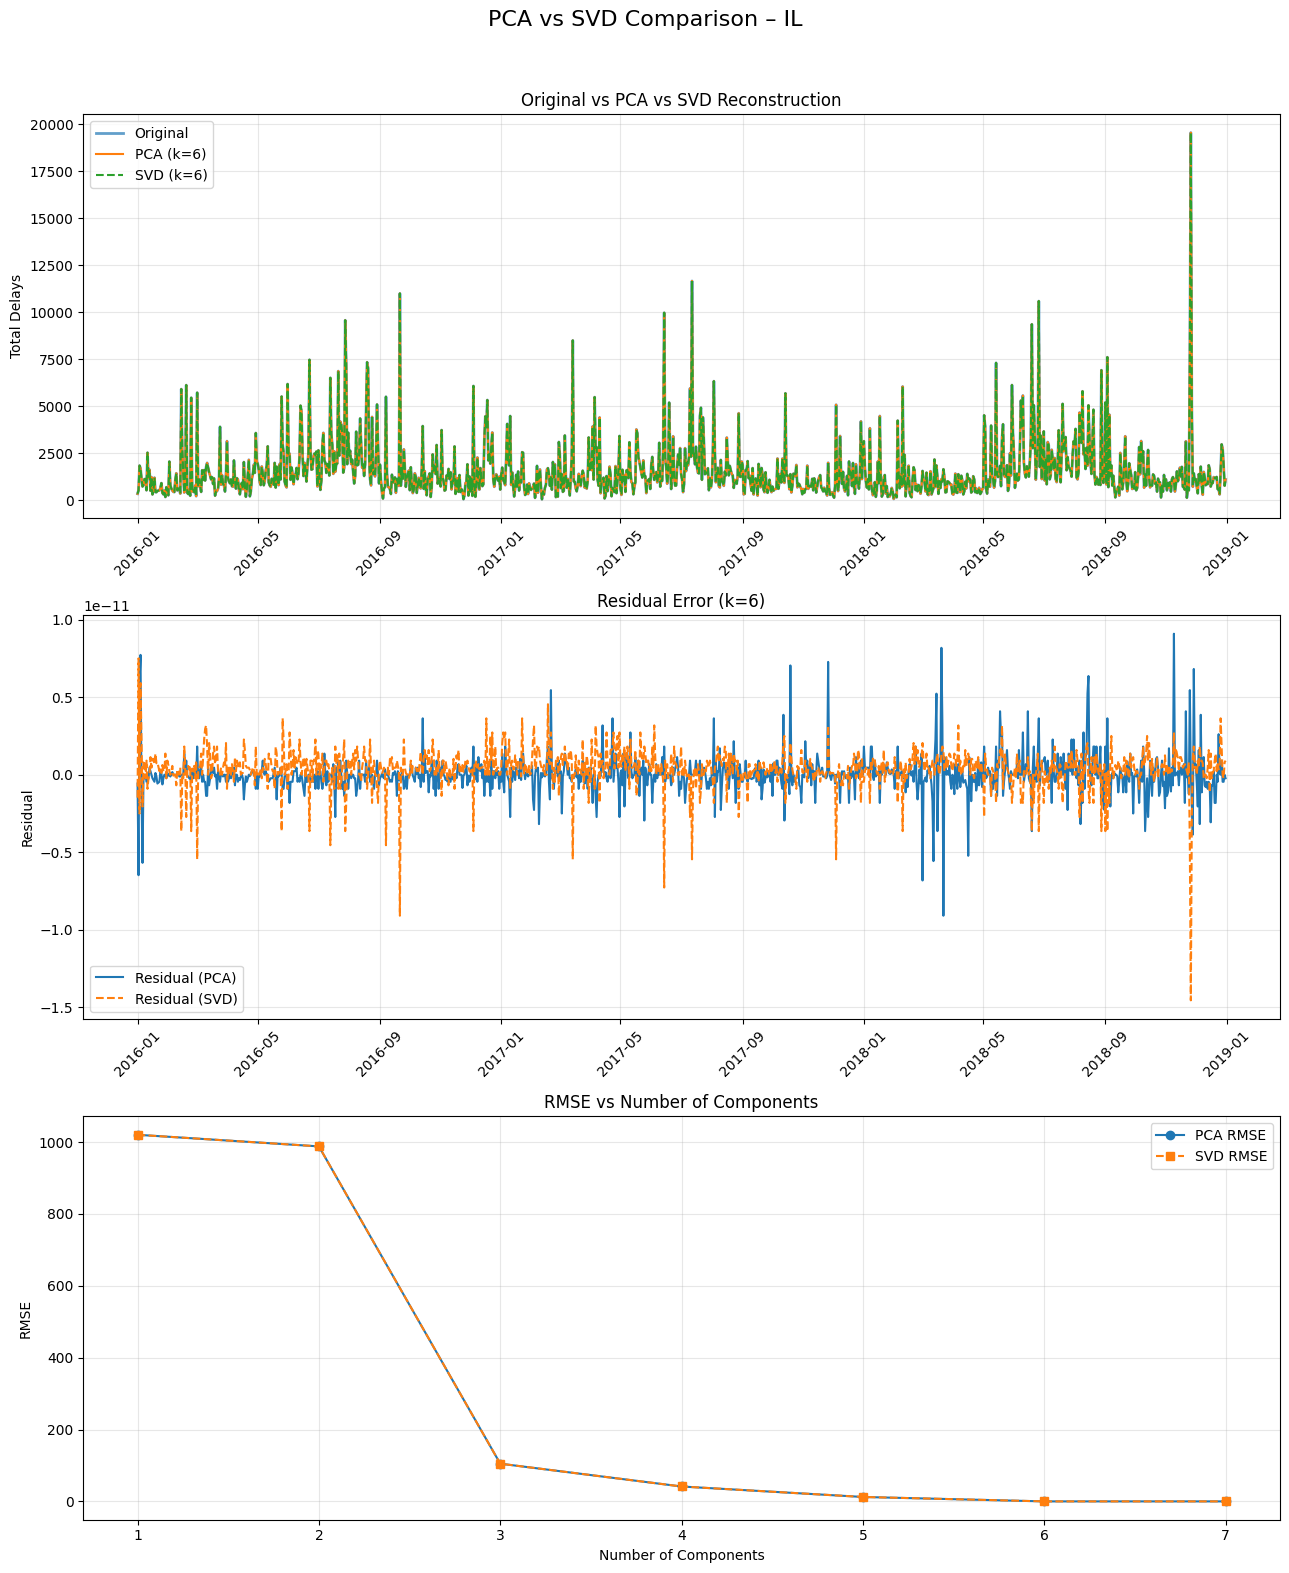

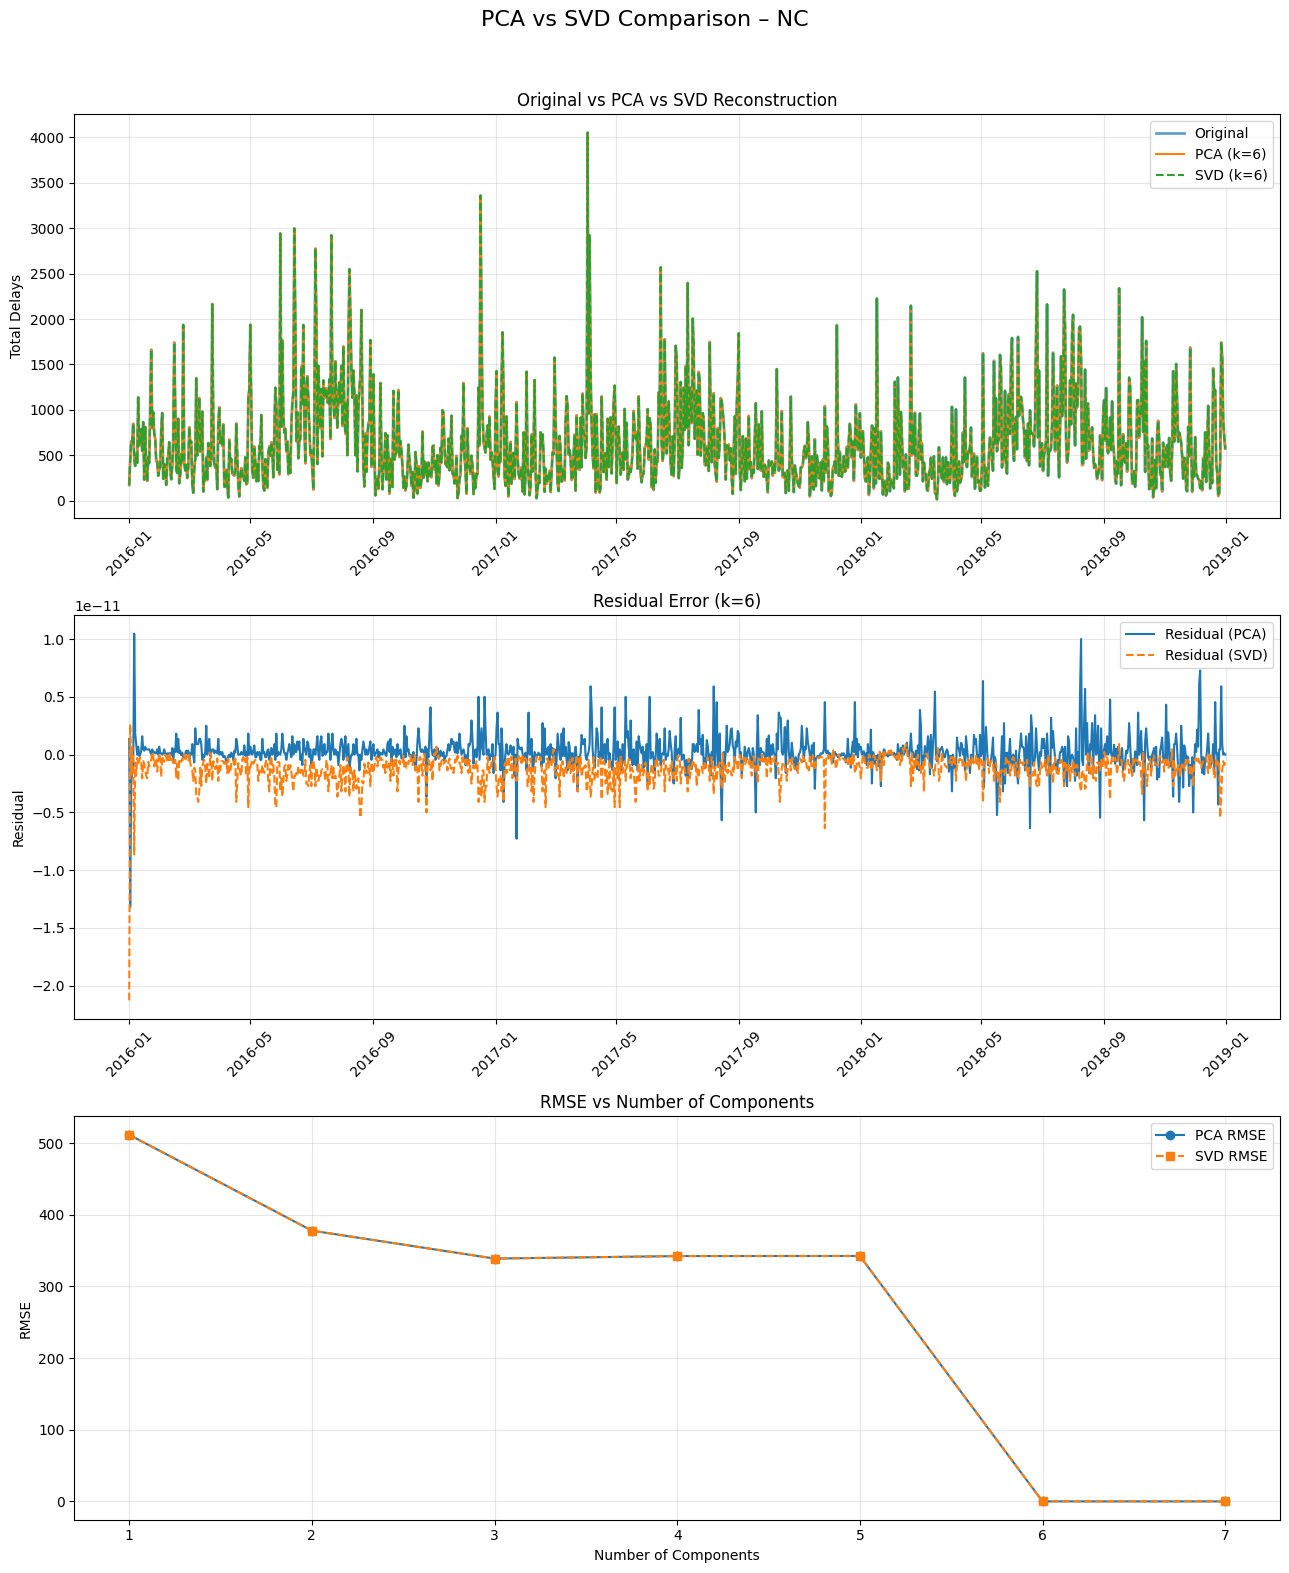

In [8]:
def compare_pca_svd(df, state):
    dates = df.columns
    x_orig = df.loc[state].values

    scaler = StandardScaler()
    X_std = scaler.fit_transform(df.values)
    df_std = pd.DataFrame(X_std, index=df.index, columns=df.columns)

    df_cov = df_std.cov()
    eigvals, eigvecs = get_sorted_eigen(df_cov)

    x_std = df_std.loc[state].values.reshape(1, -1)

    def rec_pca(k):
        V = eigvecs[:, :k]         
        scores = x_std @ V          
        x_hat = scores @ V.T    
        return scaler.inverse_transform(x_hat)[0]  

    U, S, Vt = np.linalg.svd(X_std, full_matrices=False)
    i_state = df.index.get_loc(state)

    def rec_svd(k):
        Uk = U[:, :k]             
        Sk = S[:k]                 
        Vk = Vt[:k, :]           
        Xk = (Uk * Sk) @ Vk        
        x_hat = Xk[i_state, :].reshape(1, -1)
        return scaler.inverse_transform(x_hat)[0]

    best_k = 6
    x_pca = rec_pca(best_k)
    x_svd = rec_svd(best_k)

    fig, axs = plt.subplots(3, 1, figsize=(13, 16))
    fig.suptitle(f"PCA vs SVD Comparison – {state}", fontsize=16)

    # Original vs PCA vs SVD 
    axs[0].plot(dates, x_orig, label="Original", linewidth=2, alpha=0.7)
    axs[0].plot(dates, x_pca, label=f"PCA (k={best_k})")
    axs[0].plot(dates, x_svd, label=f"SVD (k={best_k})", linestyle='--')
    axs[0].set_title("Original vs PCA vs SVD Reconstruction")
    axs[0].set_ylabel("Total Delays")
    axs[0].tick_params(axis='x', rotation=45)
    axs[0].legend()
    axs[0].grid(alpha=0.3)

    # Residuals
    res_pca = x_orig - x_pca
    res_svd = x_orig - x_svd

    axs[1].plot(dates, res_pca, label="Residual (PCA)")
    axs[1].plot(dates, res_svd, label="Residual (SVD)", linestyle='--')
    axs[1].set_title(f"Residual Error (k={best_k})")
    axs[1].set_ylabel("Residual")
    axs[1].tick_params(axis='x', rotation=45)
    axs[1].legend()
    axs[1].grid(alpha=0.3)

    #  RMSE vs components
    rmse_pca = []
    rmse_svd = []

    for j in range(1, 8):
        xp = rec_pca(j)
        xs = rec_svd(j)
        rmse_pca.append(np.sqrt(np.mean((x_orig - xp) ** 2)))
        rmse_svd.append(np.sqrt(np.mean((x_orig - xs) ** 2)))

    axs[2].plot(range(1, 8), rmse_pca, marker='o', label="PCA RMSE")
    axs[2].plot(range(1, 8), rmse_svd, marker='s', label="SVD RMSE", linestyle='--')
    axs[2].set_title("RMSE vs Number of Components")
    axs[2].set_xlabel("Number of Components")
    axs[2].set_ylabel("RMSE")
    axs[2].set_xticks(range(1, 8))
    axs[2].legend()
    axs[2].grid(alpha=0.3)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    return rmse_pca, rmse_svd, res_pca, res_svd


for state in ["AZ", "CA", "IL", "NC"]:
    compare_pca_svd(data_raw, state)

Standardization is still required, because SVD and PCA are only equivalent when the data is centered and scaled.

After standardizing the data, we ran both PCA and SVD. For every state, the reconstructed time-series from the two methods overlap almost perfectly, and their residuals and RMSE curves are basically identical. This makes sense because PCA and SVD are mathematically equivalent: SVD’s right singular vectors line up with PCA’s eigenvectors, and their singular values relate directly to PCA’s eigenvalues. Any differences you see are just tiny numerical rounding effects, not real differences between the methods.